In [47]:
# Copyright: Boris Huang @boxihuangcareer@gmail.com
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import roc_curve

from xgboost import XGBRegressor
%matplotlib inline
seed = 999 # seed to generate random numbers

In [48]:
loan_data = pd.read_csv('loan_table.csv', parse_dates=['date'],index_col='loan_id')
borrower_data = pd.read_csv('borrower_table.csv',index_col='loan_id')

loan_data.head()

,loan_purpose,date,loan_granted,loan_repaid
loan_id,,,,
19454,investment,2012-03-15,0,NaN
496811,investment,2012-01-17,0,NaN
929493,other,2012-02-09,0,NaN
580653,other,2012-06-27,1,1.0
172419,business,2012-05-21,1,0.0


In [49]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101100 entries, 19454 to 774414
Data columns (total 4 columns):
loan_purpose    101100 non-null object
date            101100 non-null datetime64[ns]
loan_granted    101100 non-null int64
loan_repaid     47654 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.9+ MB


In [50]:
borrower_data.head()

,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
loan_id,,,,,,,,,,,
289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [51]:
borrower_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101100 entries, 289774 to 761999
Data columns (total 11 columns):
is_first_loan                                      101100 non-null int64
fully_repaid_previous_loans                        46153 non-null float64
currently_repaying_other_loans                     46153 non-null float64
total_credit_card_limit                            101100 non-null int64
avg_percentage_credit_card_limit_used_last_year    94128 non-null float64
saving_amount                                      101100 non-null int64
checking_amount                                    101100 non-null int64
is_employed                                        101100 non-null int64
yearly_salary                                      101100 non-null int64
age                                                101100 non-null int64
dependent_number                                   101100 non-null int64
dtypes: float64(3), int64(8)
memory usage: 9.3 MB


In [52]:
# Rename columns in order to increase Interpretability

loan_data.rename(columns={'loan_purpose':'purpose',
                     'loan_granted':'granted',
                     'loan_repaid':'repaid'},
                        inplace = True)

borrower_data.rename(columns={'is_first_loan':'is_first',
                         'fully_repaid_previous_loans':'repay_prev',
                         'currently_repaying_other_loans':'paying_others',
                         'total_credit_card_limit':'credit_limit',
                         'avg_percentage_credit_card_limit_used_last_year':'credit_used',
                         'saving_amount':'saving',
                         'checking_amount':'checking',
                         'yearly_salary':'salary',
                         'dependent_number':'n_depends'},inplace=True)

## Data Preprocessing

The goal is to generate a ML model that can better generate profit, I plan on using XGBoost tree model in this case. 

Here are a few tasks that I will be conducting in the following cell blocks in order to make logical senses.

1. Rename columns in order to increase readability
2. Generate target column (Y - output Column)
3. Data Preprocessing (Cleaning, Feature Engineering)
4. Split data and observe the optimized probability cutoff

In [53]:
data = pd.merge(left = loan_data, right = borrower_data, on= 'loan_id')

In [54]:
data.sample(5)

,purpose,date,granted,repaid,is_first,repay_prev,paying_others,credit_limit,credit_used,saving,checking,is_employed,salary,age,n_depends
loan_id,,,,,,,,,,,,,,,
745878,home,2012-08-24,1,1.0,0,1.0,0.0,6100,0.76,2975,3293,1,11100,29,2
478602,home,2012-07-09,1,1.0,1,NaN,NaN,6600,0.97,3450,1568,1,28200,54,5
542089,business,2012-09-13,0,NaN,1,NaN,NaN,2000,1.09,1502,5261,1,53000,26,4
131310,home,2012-08-27,1,1.0,1,NaN,NaN,6600,0.70,1479,4471,1,3100,41,1
758645,other,2012-06-14,1,1.0,0,1.0,0.0,4700,0.54,5266,5456,1,33900,47,3


### Generate Target Column (For ML Modeling - Y values)

In [55]:
# Rules:
# If you grant the loan and the it doesn't get repaid, you lose 1
# If you grant the loan and the it does get repaid, you gain 1
# If you don't grant the loan, you gain 0

# Grant loan = 1, repaid = 0, profit = -1
# Grant loan = 1, repaid = 1, profit = 1
# Grant loan = 0, profit = 0

def profit_calculate_should_grant(data):
    granted = data['granted']
    repaid = data['repaid']
    
    profit = 0 
    should_grant = 0
    
    if granted == 0:
        profit = 0
        should_grant = 0
    
    else: #grant = 1
        
        if repaid == 1:
            profit = 1
            should_grant = 1 
            
        else: # repaid = 0
            assert pd.notnull(repaid)
            profit = 1
            should_grant = 0
    return pd.Series({'profit':profit,'should_grant':should_grant})



In [56]:
profit_should_grant = data.apply(profit_calculate_should_grant, axis = 1)
profit_should_grant.head()

,profit,should_grant
loan_id,,
19454,0,0
496811,0,0
929493,0,0
580653,1,1
172419,1,0


In [57]:
data = data.join(profit_should_grant)


In [59]:
data.sample(5)

,purpose,date,granted,repaid,is_first,repay_prev,paying_others,credit_limit,credit_used,saving,checking,is_employed,salary,age,n_depends,profit,should_grant
loan_id,,,,,,,,,,,,,,,,,
327237,business,2012-02-07,0,NaN,1,NaN,NaN,2900,0.44,1047,3507,0,0,21,2,0,0
651019,emergency_funds,2012-10-25,1,0.0,1,NaN,NaN,3800,0.60,723,968,1,8500,69,6,1,0
351743,investment,2012-12-25,1,1.0,0,1.0,0.0,5200,0.73,4109,6302,1,26200,34,4,1,1
969672,investment,2012-06-13,0,NaN,1,NaN,NaN,1600,0.55,773,1135,0,0,33,1,0,0
292699,emergency_funds,2012-02-07,1,1.0,1,NaN,NaN,5000,0.65,5277,8238,1,40700,35,7,1,1


### Data Preprocessing (Cleaning, Feature Engineering)

Through observation, there are redundancy within the dataset.
#### 1. Column['is_first'] & Column['repay_prev'] & Column['paying_others']

If we look closly to the dataset sample above, if it is the first loan, borrower will have 'NaN' for both "repay_prev" and "paying_other" values.

Therefore, 
    1. we can provide values to the following two columns with '-1' value when is_first = 1
    2. "is_first" column can be eliminated since "repay_prev" and "paying_others" can demonstrate whether it is first loan.

    This is all due to the fact that we are going to use xgboost tree model, which specifically looking for cutoff. 
    In this setting, the two columns will be catorgical data with potential values in [-1,0,1] and can fit into tree model.

#### 2. Column['is_employed'] & Column['Salary']
If we observe the dataset closely, if a borrower is unemployed, we know they have 0 for salary. Therefore, we can eliminate Column['is_employed'] to lower the possibility of overfitting in our tree model.

#### 3. Column['purpose']
We can utilize One-Hot-Encoding for the purpose column since we want to fit catergorical data to tree model. OHE is able to reduce the burden and allow tree model to take in numerical value instead of text.


In [86]:
# Task 1 of Data Preprocessing

X = data.copy()
X.fillna({'repay_prev': -1, 'paying_others': -1}, inplace = True)
del X['is_first']

X.head()

,purpose,date,granted,repaid,repay_prev,paying_others,credit_limit,credit_used,saving,checking,is_employed,salary,age,n_depends,profit,should_grant
loan_id,,,,,,,,,,,,,,,,
19454,investment,2012-03-15,0,NaN,-1.0,-1.0,8600,0.79,1491,6285,1,45200,42,7,0,0
496811,investment,2012-01-17,0,NaN,-1.0,-1.0,5300,0.52,141,5793,0,0,42,5,0,0
929493,other,2012-02-09,0,NaN,-1.0,-1.0,0,NaN,660,3232,1,26500,60,4,0,0
580653,other,2012-06-27,1,1.0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4,1,1
172419,business,2012-05-21,1,0.0,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4,1,0


In [87]:
# Task 2 of Data Preprocessing

del X['is_employed']

X.head()

,purpose,date,granted,repaid,repay_prev,paying_others,credit_limit,credit_used,saving,checking,salary,age,n_depends,profit,should_grant
loan_id,,,,,,,,,,,,,,,
19454,investment,2012-03-15,0,NaN,-1.0,-1.0,8600,0.79,1491,6285,45200,42,7,0,0
496811,investment,2012-01-17,0,NaN,-1.0,-1.0,5300,0.52,141,5793,0,42,5,0,0
929493,other,2012-02-09,0,NaN,-1.0,-1.0,0,NaN,660,3232,26500,60,4,0,0
580653,other,2012-06-27,1,1.0,1.0,0.0,5400,0.52,3345,2764,15800,58,4,1,1
172419,business,2012-05-21,1,0.0,-1.0,-1.0,2900,0.76,1050,3695,34800,31,4,1,0


In [88]:
# Task 3 of Data Preprocessing
# Only purpose has text values so we can directly write it like this
X = pd.get_dummies(X)

# K unique values, only need K-1 features, so remove one redundant feature
del X['purpose_other'] 

# rename to short names, which is easier to read
X.rename(columns={'purpose_emergency_funds':'purpose_emergency'},inplace=True)

In [89]:
X.sample()

,date,granted,repaid,repay_prev,paying_others,credit_limit,credit_used,saving,checking,salary,age,n_depends,profit,should_grant,purpose_business,purpose_emergency,purpose_home,purpose_investment
loan_id,,,,,,,,,,,,,,,,,,
320409,2012-09-19,1,1.0,-1.0,-1.0,3100,0.62,1704,5218,34400,40,8,1,1,1,0,0,0


In [90]:
X.to_csv("cleaned_loan_data.csv",index_label='loan_id')

### Train Model

In [91]:
y = X.loc[:,'should_grant']

feature_names = ['repay_prev', 'paying_others', 'credit_limit', 'credit_used',
                 'saving', 'checking', 'salary', 'age', 'n_depends', 
                 'purpose_business','purpose_emergency', 'purpose_home', 'purpose_investment']
X = X.loc[:,feature_names]

In [92]:
y.value_counts(normalize=True)

0    0.696281
1    0.303719
Name: should_grant, dtype: float64

Here, we can see that, 30% of the loans should be granted. Our dataset is imbalance. Therefore, we should normalize the data and change the threshold instead of using the default 50% for the probability cutoff.


In [98]:
# Split Training, test data
seed = 999 # seed to generate random numbers
import xgboost as xgb
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.3,random_state=seed)

# Split Training, Validation data
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size= 0.3, random_state=seed)

train_matrix = xgb.DMatrix(X_train,Y_train)
valid_matrix = xgb.DMatrix(X_valid,Y_valid)
test_matrix = xgb.DMatrix(X_test,Y_test)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [101]:
def train(params):
    params['silent'] = 1
    params['objective'] = 'binary:logistic'  # output probabilities
    params['eval_metric'] = 'auc'

    num_rounds = params["num_rounds"]
    early_stopping_rounds = params["early_stop_rounds"]

    # early stop will check on the last dataset
    watchlist = [(train_matrix, 'train'), (valid_matrix, 'validate')]
    bst = xgb.train(params, train_matrix, num_rounds, watchlist, early_stopping_rounds=early_stopping_rounds)

    print("parameters: {}".format(params))
    print("best {}: {:.2f}".format(params["eval_metric"], bst.best_score))
    print("best #trees: %d" % (bst.best_ntree_limit))

    return bst

In [102]:
# ------------- prepare parameters
params = {}
params["num_rounds"] = 300
params["early_stop_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

# ------------- train with xgboost
bst = train(params)

[0]	train-auc:0.87675	validate-auc:0.871425
Multiple eval metrics have been passed: 'validate-auc' will be used for early stopping.

Will train until validate-auc hasn't improved in 30 rounds.
[1]	train-auc:0.893738	validate-auc:0.888335
[2]	train-auc:0.892565	validate-auc:0.886606
[3]	train-auc:0.895494	validate-auc:0.888377
[4]	train-auc:0.89469	validate-auc:0.887475
[5]	train-auc:0.894702	validate-auc:0.887462
[6]	train-auc:0.896551	validate-auc:0.88872
[7]	train-auc:0.897616	validate-auc:0.889542
[8]	train-auc:0.899606	validate-auc:0.890938
[9]	train-auc:0.900125	validate-auc:0.891376
[10]	train-auc:0.901076	validate-auc:0.891638
[11]	train-auc:0.901528	validate-auc:0.891884
[12]	train-auc:0.902054	validate-auc:0.89222
[13]	train-auc:0.902305	validate-auc:0.892777
[14]	train-auc:0.902567	validate-auc:0.89272
[15]	train-auc:0.902882	validate-auc:0.892764
[16]	train-auc:0.90343	validate-auc:0.892951
[17]	train-auc:0.903884	validate-auc:0.893169
[18]	train-auc:0.904177	validate-auc:0.

In [104]:
n_trees = bst.best_ntree_limit
n_trees

89

### Looking for the best probability cutoff

The goal: find best 'probability cutoff' on validation set's ROC curve.


The method: Loop through all possible thresolds of validation set to local the highes profit



In [109]:
yvalid_true = valid_matrix.get_label()
yvalid_pred_probas = bst.predict(valid_matrix, ntree_limit=bst.best_ntree_limit)
fpr,tpr,thresholds = roc_curve(yvalid_true,yvalid_pred_probas)
roc = pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thresholds':thresholds})

In [114]:

def calc_profits(repaids,probas,threshold):
    total_profit = 0
    for (repaid,proba) in zip(repaids,probas):
        if proba > threshold:
            total_profit += (1 if repaid == 1 else -1)
    return total_profit

# all examples in validation sets
loan_valid = data.loc[Y_valid.index,:]

# Call function 'calc_profits' to loop thru validation set and find highest profit
valid_profits = [ calc_profits(loan_valid.repaid,yvalid_pred_probas,threshold) for threshold in roc.Thresholds]

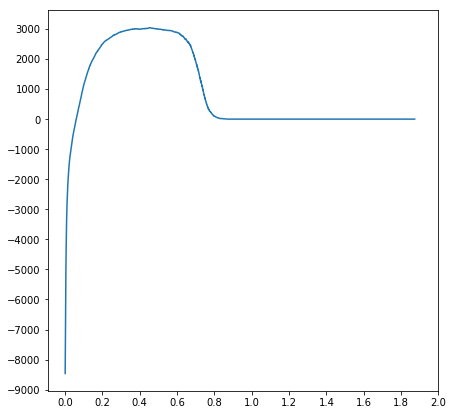

In [124]:
plt.plot(roc.Thresholds,valid_profits)
plt.yticks(range(-9000,4000,1000))
_ = plt.xticks(np.linspace(0,2,11))
plt.rc('figure',figsize=(15,15))

In [136]:
valid_threshold_profit = pd.DataFrame({'threshold':roc.Thresholds,'profit':valid_profits})

#max_thres_profit_pair = valid_threshold_profit.loc[np.argmax(np.array(valid_threshold_profit.profit),:]
max_thres_profit_pair = valid_threshold_profit.loc[  valid_threshold_profit.profit.argmax  ,:]
max_thres_profit_pair

threshold       0.452454
profit       3045.000000
Name: 3376, dtype: float64

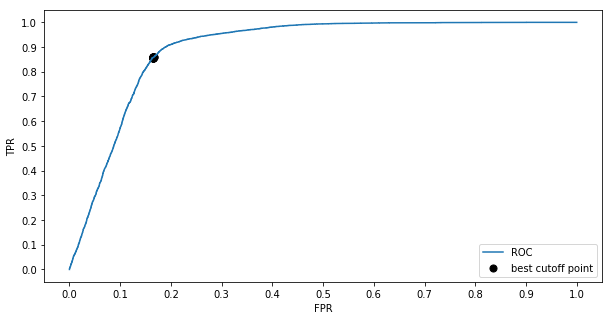

In [140]:
# plot ROC
plt.plot(roc.FPR,roc.TPR,label='ROC')
plt.xlabel("FPR")
plt.ylabel('TPR')

ticks = np.linspace(0,1,11)
plt.yticks(ticks)
plt.xticks(ticks)

# plot best thresholds
best_cutoffs = roc.loc[ (roc.Thresholds > 0.44) & (roc.Thresholds < 0.45),:]
plt.scatter(best_cutoffs.FPR,best_cutoffs.TPR,c='k',s=50,label='best cutoff point')

plt.rc('figure',figsize=(10,5))
plt.legend(loc='best')

### Retrain model with best parameter setting



In [141]:
X_all_train = pd.concat([X_train,Y_valid],axis=0)
y_all_train = pd.concat([Y_train,Y_valid],axis=0)
all_train_matrix = xgb.DMatrix(X_all_train,y_all_train)

In [143]:
watchlist = [(all_train_matrix, 'train')]
all_bst = xgb.train(params, all_train_matrix, n_trees, watchlist)

[0]	train-auc:0.920779
[1]	train-auc:0.942698
[2]	train-auc:0.946942
[3]	train-auc:0.947765
[4]	train-auc:0.947703
[5]	train-auc:0.948088
[6]	train-auc:0.947909
[7]	train-auc:0.94839
[8]	train-auc:0.948952
[9]	train-auc:0.949131
[10]	train-auc:0.949334
[11]	train-auc:0.949575
[12]	train-auc:0.949723
[13]	train-auc:0.949896
[14]	train-auc:0.949954
[15]	train-auc:0.950196
[16]	train-auc:0.950252
[17]	train-auc:0.950349
[18]	train-auc:0.950461
[19]	train-auc:0.950555
[20]	train-auc:0.950567
[21]	train-auc:0.950545
[22]	train-auc:0.950577
[23]	train-auc:0.950664
[24]	train-auc:0.950686
[25]	train-auc:0.95072
[26]	train-auc:0.950762
[27]	train-auc:0.950783
[28]	train-auc:0.950869
[29]	train-auc:0.950932
[30]	train-auc:0.950957
[31]	train-auc:0.951001
[32]	train-auc:0.950984
[33]	train-auc:0.951156
[34]	train-auc:0.951456
[35]	train-auc:0.951476
[36]	train-auc:0.951501
[37]	train-auc:0.951527
[38]	train-auc:0.951541
[39]	train-auc:0.951861
[40]	train-auc:0.951925
[41]	train-auc:0.951935
[42]

In [152]:
proba_threshold = 0.452454
ytest_pred_probas = bst.predict(test_matrix, ntree_limit = n_trees)
ytest_pred = (ytest_pred_probas > proba_threshold).astype(int)

In [154]:
print("test accuracy: ",accuracy_score(Y_test,ytest_pred))

test accuracy:  0.8439828552588197


In [157]:
print(classification_report(Y_test,ytest_pred))

              precision    recall  f1-score   support

           0       0.94      0.84      0.88     21236
           1       0.69      0.86      0.77      9094

   micro avg       0.84      0.84      0.84     30330
   macro avg       0.81      0.85      0.83     30330
weighted avg       0.86      0.84      0.85     30330



In [174]:
loan_test = data.loc[Y_test.index,:]
old_profit = loan_test.profit.sum()


In [172]:
new_profit = calc_profits(loan_test.repaid,ytest_pred_probas,proba_threshold)


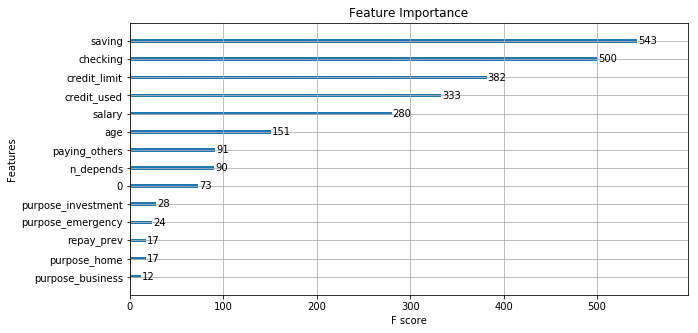

In [178]:

xgb.plot_importance(all_bst,title='Feature Importance')